In [1]:
import numpy as np
from utils import es_utils as es
from utils import itd_utils as itd
from utils import prob_utils as prob

import pickle as pkl

import matplotlib.pyplot as plt
%matplotlib inline

from python_speech_features import logfbank

from scipy.io import wavfile
import re
from scipy import stats
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import gammamix

from collections import OrderedDict
import itertools
from scipy.ndimage.filters import gaussian_filter
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

import os
import tables

import keras
import keras.backend as K
from keras.models import load_model
import sys


/home/enea/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Some routines

In [2]:
def remove_trigger(timestamps, addresses):
    dx = 0.000001
    idx =  np.argmax(np.diff(timestamps)/dx)
    return timestamps[idx + 1:], addresses[idx + 1:]

def wind_sp(ts, ch, w=0.001):
    ts_int = (ts // w).astype('int32')
    if len(ts_int) < 1:
        ts_int = np.array([0,0])

    A = np.zeros((np.max(ts_int) + 3000, 64))
    A += np.abs(np.random.randn(A.shape[0], A.shape[1]))

    for _t, _c in zip(ts_int, ch):
        A[_t, _c] += 100
    
#     A = np.minimum(A, np.ones_like(A))
    # returning [ch, T]
    return A.T

def exp_feat(A, win=0.05, tpe='lap', l=300):
    if tpe == 'exp':
        t = np.arange(0, win, 0.001)
        b = np.exp(-l * t)
    elif tpe == 'lap':
        t = np.arange(-win, win, 0.001)
        b = np.exp(-l * np.abs(t))
        
    b /= np.linalg.norm(b)
    AA = np.array([np.convolve(_a, b, 'same') for _a in A])
    return AA

def smear_fr(A, win=3, l=10):
#     t = np.arange(-win, win, 1)
#     b = np.exp(-l * np.abs(t))
#     b = np.concatenate([np.arange(win), np.arange(win)[::-1]])
#     A = np.array([np.convolve(_a, b, 'same') for _a in A.T])
    A = gaussian_filter(A, 1)
    return A

def simple_low_pass(X, win=60, shift=40):
    n_win = (X.shape[0] - win) // shift
    XX = np.zeros((n_win, X.shape[1]))
    for i in range(0, n_win):
        XX[i] = np.sum(X[i * shift: (i + 1) * shift] , 0) / win
    return XX

def spike_features(T1, C1):
    A = wind_sp(np.array(T1), np.array(C1).astype('int32'))
    AA = exp_feat(A, win=0.05, l=30, tpe='lap')
    AAA = smear_fr(AA, win=3)
    AAAA = simple_low_pass(AAA.T).T
    
    return np.log10(AAAA + 1e-9)

def get_ctx_win(X, Y, ctx=5, shift=1):
    n_win = (X.shape[1] - ctx * 2) // shift
    X_re = np.array([X[:, i - ctx:i + ctx + 1].reshape(-1,) for i in range(ctx, n_win * shift, shift)])
    Y_re = Y[:, ctx + 1:-(ctx * 2 - 1)].T
    return X_re, Y_re

def find_local_maxima(x, win=5):
    to_pad = win // 2
    x = np.pad(x, (to_pad,to_pad), 'constant', constant_values=(0, 0))
    idx = []
    for i in range(to_pad, len(x) - to_pad):
        if np.argmax(x[i - to_pad: i + to_pad]) == to_pad:
            idx.append(i - to_pad)
    return np.array(idx)

def correct_pos(pos):
    if pos == 0:
        pos = 1
    if pos == 18:
        pos = 17
    return pos


# SPS

In [3]:
def sps(idx, subset, sigma=20, channels=np.arange(64)):
    
    filename = basedir + 'aedat/{}/'.format(subset) + ALL_NAMES[subset][IDX] + '.aedat'
    
    # load / trigger / decode
    timestamps, addresses = es.loadaerdat(filename)
#     timestamps, addresses = remove_trigger(timestamps, addresses)
    timestamps, channel_id, ear_id, neuron_id, filterbank_id = es.decode_ams1c(timestamps, addresses, return_type=False)

    # load wavs
    spk1, spk2, _ = re.compile('[0-9]+').split(ALL_NAMES[subset][IDX])
    _, utt1, utt2 = re.compile('[A-Z]+').split(ALL_NAMES[subset][IDX])
    
    angles = ALL_ANGLES[subset][IDX].split(' ')
    pos1, pos2 = int(float(angles[1]) // 10), int(float(angles[2]) // 10)
    pos1, pos2 = correct_pos(pos1), correct_pos(pos2)
    pos = [pos1, pos2]
    
    fs, w1 = wavfile.read(basedir + 'wavs/{}/'.format(subset) + GTS1[subset][IDX].replace('\\', '/') + '.wav')
    fs, w2 = wavfile.read(basedir + 'wavs/{}/'.format(subset) + GTS2[subset][IDX].replace('\\', '/') + '.wav')
    
    # get itd and fix them
    _aa = {}
    idx_dict = {}
    for kk in channels:
        indices_channels = np.isin(channel_id, np.array([kk]))
        if kk in DICT_C:
            try:
                _itds, _itd_idx = itd.get_itds(timestamps[indices_channels], ear_id[indices_channels], neuron_id[indices_channels], save_to_file=None,
                                     verbose=False, max_itd=max_itd)
                idx_dict[kk] = _itd_idx
                _mu = DICT_C[kk]['mu']
                _corr = (_itds - _mu)  
                _aa[kk] = _corr
            except Exception as e:
                pass

    # get probabilities
    index_angles = np.vstack([np.arange(19), np.arange(0, 190, 10)]).T

    num_angles = len(PRIORS)
    initial_estimate = np.ones(num_angles) / num_angles # all angles are a priori equally likely
    transition_probabilities = prob.get_transition_probabilities(index_angles, sigma=sigma) # gaussian a priori probability of itds given a certain position
    
    arg = {}
    for k, _a in _aa.iteritems():
        estimates, argmax_estimates = prob.estimate(_a, initial_estimate, transition_probabilities, ITD_DICT, PRIORS)
        arg[k] = argmax_estimates
        
    amax = np.array(list(itertools.chain.from_iterable([v for _, v in arg.iteritems()])))
    
    # get separated spikes
    T = []
    C = []
    for p in [pos1, pos2]:
        T1 = []
        C1 = []
        for ch in idx_dict.keys():
            t = (timestamps[channel_id == ch])[idx_dict[ch][arg[ch] == p]]
            T1.extend(t)
            C1.extend(np.ones_like(t) * ch)
        T.append(T1)
        C.append(C1)
    
    return T, C, w1, w2, fs, amax, pos
    

# Some data preparation

In [4]:
basedir = '/Data/DATASETS/CAESAR_TIDIGITS/'

num_bins = 80
max_itd = 800e-6
num_channels = 64

ALL_ANGLES = {}
ALL_NAMES = {}
GTS1 = {}
GTS2 = {}

with open(basedir + 'log_train.txt') as t:
    ALL_ANGLES['train'] = [x for x in t.readlines()]

with open(basedir + 'log_test.txt') as t:
    ALL_ANGLES['test'] = [x for x in t.readlines()]

with open('train_set.txt') as t:
    ALL_NAMES['train'] = [line.split(' ')[4].strip() for line in t.readlines()]
with open('train_set.txt') as t:
    GTS1['train'] = [line.split(' ')[0].strip() for line in t.readlines()]
with open('train_set.txt') as t:
    GTS2['train'] = [line.split(' ')[1].strip() for line in t.readlines()]
    
with open('test_set.txt') as t:
    ALL_NAMES['test'] = [line.split(' ')[4].strip() for line in t.readlines()]
with open('test_set.txt') as t:
    GTS1['test'] = [line.split(' ')[0].strip() for line in t.readlines()]
with open('test_set.txt') as t:
    GTS2['test'] = [line.split(' ')[1].strip() for line in t.readlines()]
    
PRIORS = np.load('priors_long_hv_corrected_all.npy')
DICT_C = pkl.load(open('correction_dict.pkl', 'r'))
ITD_DICT = itd.get_itd_dict(max_itd, num_bins) 


# Loading example

In [ ]:
IDX = 1850
subset = 'test'

ch = np.arange(0,64)
T, C, w1, w2, fs, amax, pos = sps(IDX, subset=subset, sigma=180, channels=ch)

spkf1 = spike_features(T[0], C[0])[2:]
spkf2 = spike_features(T[1], C[1])[2:]

# w_spk1 = get_ctx_win(spkf1[::-1])
# w_spk2 = get_ctx_win(spkf2[::-1])

fig = plt.figure(figsize=(20, 5))

for spkf, k, w in zip([spkf1, spkf2], range(2), [w1, w2]):
    
    ax = fig.add_subplot(2, 3, k*3 + 2)
    Y = logfbank(w, fs, nfft=2048,winlen=0.06,winstep=0.04)
    ax.imshow(Y.T, aspect='auto')
    
    ax = fig.add_subplot(2, 3, k*3 + 1)
    ax.imshow(spkf[:, :Y.shape[0]], aspect='auto')


In [ ]:
A = np.arange(0, 200, 10)
a = plt.hist(amax, int(np.max(amax)), normed=True)

b = np.linspace(0, 19, 19)

gmm = GaussianMixture(2, n_init=20)
gmm.fit(amax.reshape(-1,1))
plt.figure()
g1 = norm.pdf(b, gmm.means_[0], gmm.covariances_[0][0])
g2 = norm.pdf(b, gmm.means_[1], gmm.covariances_[1][0])
# g3 = norm.pdf(b, gmm.means_[2], gmm.covariances_[2][0])
plt.plot(g1 / np.max(g1))
plt.plot(g2 / np.max(g2))
# plt.plot(g3 / np.max(g3))

print A[np.argmax(g1)]
print A[np.argmax(g2)]
print pos

# Check precision in localization 

In [ ]:
sys.stdout.flush()
acc = 0.
count = 0.
for IDX in tqdm(range(5999)):
    pos1, pos2 = int(float(all_angles[IDX].split(' ')[1]) // 10) , int(float(all_angles[IDX].split(' ')[2]) // 10)
#     if pos1 != pos2: 
    if np.abs(pos1 - pos2) >= 2:  # non-adiacent or same spot
        p = np.sort([correct_pos(pos1), correct_pos(pos2)])
        ch = np.arange(15,30)
        T, C, w1, w2, fs, amax = sps(basedir + 'aedat/train/' + all_train[IDX] + '.aedat', sigma=5, channels=ch)
        a = np.histogram(amax, 19, range=[0, 18], normed=True)
        ii = find_local_maxima(a[0])
        
        kk = np.sort(ii[np.argsort(a[0][ii])[::-1][:2]])
        if len(kk) == 2:
            if np.abs(p[0] - kk[0]) <= 1 and np.abs(p[1] - kk[1]) <= 1:
                acc += 1.
            count += 1.
print acc / count * 100

# How many are same position or adiacent

In [ ]:
sys.stdout.flush()
idx_0_train = []
idx_1_train = []
idx_0_test = []
idx_1_test = []
acc = 0.
count = 0.
for IDX in range(1999):
    pos1, pos2 = int(float(all_angles_test[IDX].split(' ')[1]) // 10) , int(float(all_angles_test[IDX].split(' ')[2]) // 10)
    pos1, pos2 = correct_pos(pos1), correct_pos(pos2)
    if pos1 == pos2:
        count += 1.
        idx_0_test.append(IDX)

print "TEST: same angle in {:.2} % of the cases ({})".format(count / 1999 * 100, len(idx_0_test))

count = 0.
for IDX in range(5999):
    pos1, pos2 = int(float(all_angles[IDX].split(' ')[1]) // 10) , int(float(all_angles[IDX].split(' ')[2]) // 10)
    pos1, pos2 = correct_pos(pos1), correct_pos(pos2)
    if pos1 == pos2:
        count += 1.
        idx_0_train.append(IDX)
        
print "TRAIN: same angle in {:.3} % of the cases ({})".format(count / 5999 * 100, len(idx_0_train))

sys.stdout.flush()
acc = 0.
count = 0.
for IDX in range(1999):
    
    pos1, pos2 = int(float(all_angles_test[IDX].split(' ')[1]) // 10) , int(float(all_angles_test[IDX].split(' ')[2]) // 10)
    pos1, pos2 = correct_pos(pos1), correct_pos(pos2)
    if np.abs(pos1 - pos2) == 1:
        count += 1.
        idx_1_test.append(IDX)

print "TEST: adiacent angle in {:.2} % of the cases ({})".format(count / 1999 * 100, len(idx_1_test))

count = 0.
for IDX in range(5999):
    pos1, pos2 = int(float(all_angles[IDX].split(' ')[1]) // 10) , int(float(all_angles[IDX].split(' ')[2]) // 10)
    pos1, pos2 = correct_pos(pos1), correct_pos(pos2)
    if np.abs(pos1 - pos2) == 1:
        count += 1.
        idx_1_train.append(IDX)
        
print "TRAIN: adiacent angle in {:.3} % of the cases ({})".format(count / 5999 * 100, len(idx_1_train))

ang_diff_test = []

for IDX in range(1999):
    pos1, pos2 = int(float(all_angles_test[IDX].split(' ')[1]) // 10) , int(float(all_angles_test[IDX].split(' ')[2]) // 10)
    pos1, pos2 = correct_pos(pos1), correct_pos(pos2)
    ang_diff_test.append(np.abs(pos1 - pos2))
    
ang_diff_train = []

for IDX in range(5999):
    pos1, pos2 = int(float(all_angles[IDX].split(' ')[1]) // 10) , int(float(all_angles[IDX].split(' ')[2]) // 10)
    pos1, pos2 = correct_pos(pos1), correct_pos(pos2)
    ang_diff_train.append(np.abs(pos1 - pos2))
    
fig = plt.figure()
ax = fig.add_subplot(1,2,1)
_ = ax.hist(ang_diff_train, 16, normed=True)
ax.set_title('train')
ax = fig.add_subplot(1,2,2)
_ = ax.hist(ang_diff_test, 16, normed=True)
ax.set_title('test')

plt.tight_layout()

# Load and shift correctly

In [ ]:
IDX = 388
subset = 'test'

h5file = '/Data/DATASETS/CAESAR_TIDIGITS/tidigits_log_mix.h5'

h5 = tables.open_file(h5file, 'r')
dataset = h5.get_node(os.path.join(os.sep, 'default', subset))

channels = h5.list_nodes(os.path.join(os.sep, 'default', subset))

print ALL_NAMES[subset][IDX]
timestamps, addresses = es.loadaerdat(basedir + 'aedat/{}/'.format(subset) + ALL_NAMES[subset][IDX] + '.aedat')
timestamps, addresses = remove_trigger(timestamps, addresses)

timestamps, channel_id, ear_id, neuron_id, filterbank_id = es.decode_ams1c(timestamps, addresses, return_type=False)

# load wav
spk1, spk2, _ = re.compile('[0-9]+').split(ALL_NAMES[subset][IDX])
_, utt1, utt2 = re.compile('[A-Z]+').split(ALL_NAMES[subset][IDX])
pos1, pos2 = int(float(ALL_ANGLES[subset][IDX].split(' ')[1]) // 10) , int(float(ALL_ANGLES[subset][IDX].split(' ')[2]) // 10)
print pos1
print pos2
fs, w1 = wavfile.read(basedir + 'wavs/{}/'.format(subset) + GTS1[subset][IDX].replace('\\', '/') + '.wav')
fs, w2 = wavfile.read(basedir + 'wavs/{}/'.format(subset) + GTS2[subset][IDX].replace('\\', '/') + '.wav')

fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(2,1,1)

m_len = max([len(w1), len(w2)])
w1 = np.concatenate([w1, np.zeros(m_len - len(w1),)])
w2 = np.concatenate([w2, np.zeros(m_len - len(w2),)])

print m_len

Y = np.reshape(channels[0].features[IDX], channels[0].feature_shape[IDX])[:, :41]

print Y.shape
ax.imshow(Y.T, aspect='auto')
# ax.plot(np.sum(Y, 1) / 400.0 * 20, 'r')
ax.invert_yaxis()

ax = fig.add_subplot(2,1,2)

K = spike_features(timestamps, channel_id)[2:]

env_log = np.sum(Y, 1)
env_sps = np.sum(K, 0)

k = np.correlate(env_log, env_sps, 'full')

shift = np.argmax(np.abs(k)) - len(env_sps)
print shift

ax.imshow(K[::-1, np.abs(shift):], aspect='auto')
# ax.plot(np.sum(K, 0) / 1000.0 * 10 + 20, 'r')
ax.invert_yaxis()

# ax.plot(np.sum(K, 0) / 1000.0 * 25, 'r')
# ax.imshow(np.log10(wind_sp(timestamps, channel_id) + 1e-9), aspect='auto')
# ax.plot(timestamps, channel_id, 'o')
ax.set_xlim([0, Y.shape[0]])
# ax.plot()

fig = plt.figure()
ax = fig.add_subplot(2,1,1)
ax.set_xlim([0, Y.shape[0]])
ax.plot(np.sum(Y, 1) / 400.0 * 20, 'r')
ax = fig.add_subplot(2,1,2)
ax.plot(np.sum(K, 0) / 1000.0 * 10 + 20, 'r')
ax.set_xlim([0, Y.shape[0]])

h5.close()

In [ ]:
IDX = 388
subset = 'test'

h5file = '/Data/DATASETS/CAESAR_TIDIGITS/tidigits_log_mix.h5'

h5 = tables.open_file(h5file, 'r')
dataset = h5.get_node(os.path.join(os.sep, 'default', subset))

channels = h5.list_nodes(os.path.join(os.sep, 'default', subset))

print ALL_NAMES[subset][IDX]
timestamps, addresses = es.loadaerdat(basedir + 'aedat/{}/'.format(subset) + ALL_NAMES[subset][IDX] + '.aedat')
plt.plot(timestamps)

# Create dataset with alligned log/spikes

In [ ]:
all_log = {'train': [], 'test': []}
all_spk = {'train': [], 'test': []}

h5file = '/Data/DATASETS/CAESAR_TIDIGITS/tidigits_log_mix.h5'

h5 = tables.open_file(h5file, 'r')

channels = h5.list_nodes(os.path.join(os.sep, 'default', 'train'))

for subset in ['train', 'test']:
    print "DOING {}".format(subset)
    channels = h5.list_nodes(os.path.join(os.sep, 'default', subset))
    
    for IDX in tqdm(range(len(ALL_NAMES[subset]))):
        timestamps, addresses = es.loadaerdat(basedir + 'aedat/{}/'.format(subset) + ALL_NAMES[subset][IDX] + '.aedat')
        timestamps, addresses = remove_trigger(timestamps, addresses)

        timestamps, channel_id, ear_id, neuron_id, filterbank_id = es.decode_ams1c(timestamps, addresses, return_type=False)

        Y = np.reshape(channels[0].features[IDX], channels[0].feature_shape[IDX])[:, :41]

        K = spike_features(timestamps, channel_id)[2:]

        env_log = np.sum(Y, 1)
        env_sps = np.sum(K, 0)

        k = np.correlate(env_log, env_sps, 'full')

        shift = np.argmax(np.abs(k)) - len(env_sps)

        K = K[:, np.abs(shift):]
        K = K[:, :Y.shape[0]]
        Y = Y.T

        if K.shape[1] != Y.shape[1]:
            print K.shape
            print Y.shape
            raise ValueError()
        all_log[subset].append(Y)
        all_spk[subset].append(K)


h5.close()

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(2,2,1)
ax.imshow(all_spk['train'][3], aspect='auto')
ax = fig.add_subplot(2,2,3)
ax.imshow(all_log['train'][3], aspect='auto')
ax = fig.add_subplot(2,2,2)
ax.imshow(all_spk['test'][3], aspect='auto')
ax = fig.add_subplot(2,2,4)
ax.imshow(all_log['test'][3], aspect='auto')

In [ ]:
pkl.dump({'log': all_log['train'], 'spk': all_spk['train']}, open('all_log_spk_train.pkl', 'w'))
pkl.dump({'log': all_log['test'], 'spk': all_spk['test']}, open('all_log_spk_test.pkl', 'w'))

# Load data and train reconstruction model (MLP) 

In [5]:
print "TRAIN:"
all_mix_log = pkl.load(open('all_log_spk_train.pkl', 'r'))['log']
print "\tMIX LOG => {}".format(len(all_mix_log))
all_mix_spk = pkl.load(open('all_log_spk_train.pkl', 'r'))['spk']
print "\tMIX SPK => {}".format(len(all_mix_spk))
print "TEST:"
all_mix_log_test = pkl.load(open('all_log_spk_test.pkl', 'r'))['log']
print "\tMIX LOG => {}".format(len(all_mix_log_test))
all_mix_spk_test = pkl.load(open('all_log_spk_test.pkl', 'r'))['spk']
print "\tSPK LOG => {}".format(len(all_mix_spk_test))

# I also use the samples from spk_sep train
print "TRAIN:"
all_sep_log = pkl.load(open('all_sep_spk_train.pkl', 'r'))['log']
print "\tSEP LOG => {}".format(len(all_sep_log))
all_sep_spk = pkl.load(open('all_sep_spk_train.pkl', 'r'))['spk']
print "\tSEP SPK => {}".format(len(all_sep_spk))
print "TEST:"
all_sep_log_test = pkl.load(open('all_sep_spk_test.pkl', 'r'))['log']
print "\tSEP LOG => {}".format(len(all_sep_log_test))
all_sep_spk_test = pkl.load(open('all_sep_spk_test.pkl', 'r'))['spk']
print "\tSEP SPK => {}".format(len(all_sep_spk_test))

TRAIN:
	MIX LOG => 5999
	MIX SPK => 5999
TEST:
	MIX LOG => 1999
	SPK LOG => 1999
TRAIN:
	SEP LOG => 11998
	SEP SPK => 11998
TEST:
	SEP LOG => 3998
	SEP SPK => 3998


In [6]:
# to train I use the all mix plus the separated train
# all_x_train = all_mix_spk + all_mix_spk_test + all_sep_spk
# all_y_train = all_mix_log + all_mix_log_test + all_sep_log
# or only the separated one
all_x_train = all_sep_spk
all_y_train = all_sep_log

Y_train = np.concatenate(all_y_train, 1)
print Y_train.shape
X_train = np.concatenate(all_x_train, 1)
print X_train.shape

Y_test = np.concatenate(all_sep_log_test, 1)
print Y_test.shape
X_test = np.concatenate(all_sep_spk_test, 1)
print X_test.shape

(41, 511147)
(62, 511147)
(41, 168602)
(62, 168602)


In [7]:
ctx = 7
shift = 1
X_train, Y_train = get_ctx_win(X_train, Y_train, ctx=ctx, shift=shift)
print X_train.shape
print Y_train.shape

X_test, Y_test = get_ctx_win(X_test, Y_test, ctx=ctx, shift=shift)
print X_test.shape 
print Y_test.shape

(511126, 930)
(511126, 41)
(168581, 930)
(168581, 41)


# Keras Regression

In [38]:
import keras
from keras.layers import Dense, Dropout

model = keras.Sequential()
model.add(Dense(512, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(41, activation='relu'))

model.compile(optimizer='adam', loss='mse')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 512)               476672    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               262656    
__________

In [39]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
mc = keras.callbacks.ModelCheckpoint('./spk2log_only_sep.h5', monitor='val_loss', save_best_only=True)
_ = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, verbose=True, batch_size=1024, callbacks=[es, mc])

Train on 511126 samples, validate on 168581 samples
Epoch 1/100
511126/511126 [==============================] - 7s 14us/step - loss: 25.4796 - val_loss: 46.0280
Epoch 2/100
511126/511126 [==============================] - 6s 12us/step - loss: 19.4608 - val_loss: 49.8623
Epoch 3/100
511126/511126 [==============================] - 6s 12us/step - loss: 18.7820 - val_loss: 36.5379
Epoch 4/100
511126/511126 [==============================] - 6s 13us/step - loss: 11.4703 - val_loss: 10.7408
Epoch 5/100
511126/511126 [==============================] - 7s 13us/step - loss: 9.6076 - val_loss: 10.1258
Epoch 6/100
511126/511126 [==============================] - 6s 12us/step - loss: 9.4939 - val_loss: 9.6815
Epoch 7/100
511126/511126 [==============================] - 6s 12us/step - loss: 9.3907 - val_loss: 9.2368
Epoch 8/100
511126/511126 [==============================] - 7s 13us/step - loss: 9.3224 - val_loss: 9.5446
Epoch 9/100
511126/511126 [==============================] - 6s 12us/step -

In [8]:
# load model
model = load_model('spk2log_only_sep.h5')

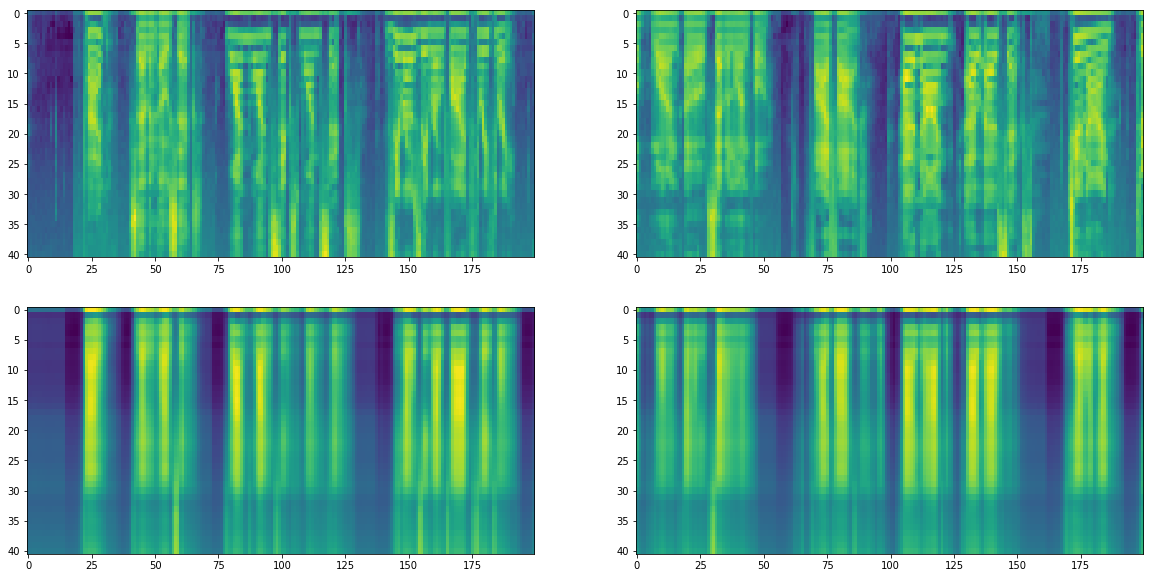

In [9]:
# visually, train vs test
f, ax = plt.subplots(2, 2, figsize=(20,10))
Y_pred_train = model.predict(X_train)
Y_pred_test = model.predict(X_test)

ax[0][0].imshow(Y_test.T[:, 1000:1200], aspect='auto')
ax[1][0].imshow(Y_pred_test.T[:, 1000:1200], aspect='auto')

ax[0][1].imshow(Y_train.T[:, 1000:1200], aspect='auto')
ax[1][1].imshow(Y_pred_train.T[:, 1000:1200], aspect='auto')

# SKLEARN Regression

In [ ]:
lr = MLPRegressor(hidden_layer_sizes=(256, 256), verbose=True, early_stopping=True)
lr.fit(X_train, Y_train)

Y_pred = lr.predict(X_test)

In [ ]:
# pkl.dump(lr, open('mlp_256_256_spk2log.pkl', 'wb'))
lr = pkl.load(open('mlp_256_256_spk2log.pkl', 'r')) 

In [ ]:
Y_pred_train = lr.predict(X_train)
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(2,1,1)
ax.imshow(Y_train.T[:, 1000:1200], aspect='auto')
ax = fig.add_subplot(2,1,2)
ax.imshow(Y_pred_train.T[:, 1000:1200], aspect='auto')

In [ ]:
Y_pred = lr.predict(X_test)
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(2,1,1)
ax.imshow(Y_test.T[:, 1000:1200], aspect='auto')
ax = fig.add_subplot(2,1,2)
ax.imshow(Y_pred.T[:, 1000:1200], aspect='auto')

# Single Sample

In [ ]:
# single sample 
regressor = model # lr
IDX = 1002
ctx = 3
shift = 1

ex_x = all_sep_spk_test[IDX]
ex_y = all_sep_log_test[IDX]

n_win = (ex_x.shape[1] - ctx * 2) // shift

ex_x, ex_y = get_ctx_win(ex_x, ex_y, ctx=ctx, shift=shift)
# print ex_x.shape 
# print ex_y.shape

ex_pred = regressor.predict(ex_x)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(3,1,1)
ax.imshow(ex_y.T, aspect='auto')
ax = fig.add_subplot(3,1,2)
ax.imshow(ex_pred.T, aspect='auto')
ax = fig.add_subplot(3,1,3)
d1 = np.diff(ex_pred, axis=1)
d2 = np.diff(d1, axis=1)
print ex_pred[:, 2:].shape
print d1[:, 1:].shape
print d2.shape
deltas = np.concatenate([ex_pred[:, 2:], d1[:, 1:], d2], axis=1)
print deltas.shape
ax.imshow(deltas.T, aspect='auto')


## Project all dataset

In [19]:
# single sample 
regressor = model # lr
ctx = 3
shift = 1

all_y = {'train': [], 'test': []}
all_lbl = {'train': pkl.load(open('all_sep_spk_train.pkl', 'r'))['lbl'], 'test': pkl.load(open('all_sep_spk_test.pkl', 'r'))['lbl']} 

for task, x, y in zip(['train', 'test'], [all_sep_spk, all_sep_spk_test], [all_sep_log, all_sep_log_test]): 
    for ex_x, ex_y in tqdm(zip(x, y)):
        ex_x, ex_y = get_ctx_win(ex_x, ex_y, ctx=ctx, shift=shift)

        ex_pred = regressor.predict(ex_x)
        all_y[task].append(ex_pred.T)

print len(all_y['train'])
print len(all_lbl['train'])
print len(all_y['test'])
print len(all_lbl['test'])

100%|██████████| 3998/3998 [00:07<00:00, 508.83it/s]

11998
11998
3998
3998


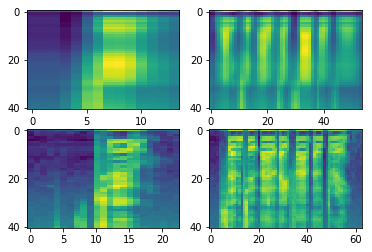

In [20]:
# double check
IDX = 1002
f, ax = plt.subplots(2,2)
ax[0][0].imshow(all_y['train'][IDX], aspect='auto')
ax[1][0].imshow(all_sep_log[IDX], aspect='auto')
ax[0][1].imshow(all_y['test'][IDX], aspect='auto')
ax[1][1].imshow(all_sep_log_test[IDX], aspect='auto')

In [21]:
# save it
pkl.dump({'spk': all_y['train'], 'lbl': all_lbl['train']}, open('all_log_prj_train.pkl', 'w'))
pkl.dump({'spk': all_y['test'], 'lbl': all_lbl['test']}, open('all_log_prj_test.pkl', 'w'))

## Check what kind of error distribution there is in reconstruction

In [20]:
regressor = model

# Y_pred = regressor.predict(X_test)
Q_test = (Y_pred_test - Y_test).reshape(-1)

# Y_pred_train = regressor.predict(X_train)
Q_train = (Y_pred_train - Y_train).reshape(-1)

print Q_train.shape

(20956166,)


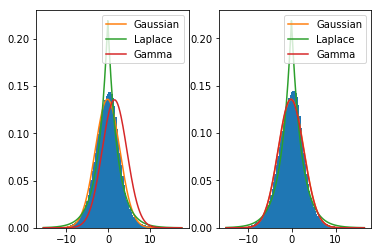

In [25]:
f, ax = plt.subplots(1, 2)
# test error distribution

a = ax[0].hist(Q_train, 100, normed=True)
xt = a[1]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(Q_train))

# gaussian
an, bn = stats.norm.fit(Q_train)  
pdf_norm = stats.norm.pdf(lnspc, an, bn)  
ax[0].plot(lnspc, pdf_norm, label="Gaussian")

# laplace
al, bl = stats.laplace.fit(Q_train)  
pdf_laplace = stats.laplace.pdf(lnspc, al, bl)  
ax[0].plot(lnspc, pdf_laplace, label="Laplace")

# gamma
ag, bg, cg = stats.gamma.fit(Q_train)  
pdf_gamma = stats.gamma.pdf(lnspc, ag, bg, cg)  
ax[0].plot(lnspc, pdf_gamma, label="Gamma")

ax[0].legend()

a = ax[1].hist(Q_test, 100, normed=True)
xt = a[1]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(Q_test))

# gaussian
an, bn = stats.norm.fit(Q_test)  
pdf_norm = stats.norm.pdf(lnspc, an, bn)  
ax[1].plot(lnspc, pdf_norm, label="Gaussian")

# laplace
al, bl = stats.laplace.fit(Q_test)  
pdf_laplace = stats.laplace.pdf(lnspc, al, bl)  
ax[1].plot(lnspc, pdf_laplace, label="Laplace")

# laplace
ag, bg, cg = stats.gamma.fit(Q_test)  
pdf_gamma = stats.gamma.pdf(lnspc, ag, bg, cg)  
ax[1].plot(lnspc, pdf_gamma, label="Gamma")

ax[1].legend()

-0.18644778
2.9435349


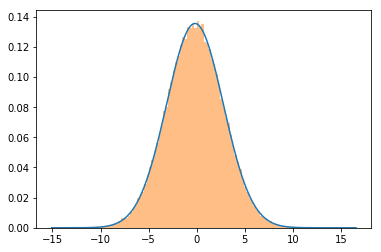

In [46]:
mu, sigma = stats.norm.fit(Q_test)  
pdf_norm = stats.norm.pdf(lnspc, mu, sigma)  
plt.plot(lnspc, pdf_norm, label="Gaussian")

y = np.random.normal(size=100000) * sigma + mu
_ = plt.hist(y, 100, normed=True, label='numpy', alpha=0.5)

print mu
print sigma

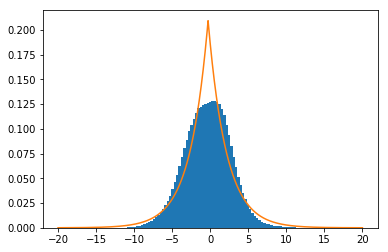

In [42]:
# plot normed histogram
plt.hist(Q.reshape(-1), 100, normed=True)

# find minimum and maximum of xticks, so we know
# where we should compute theoretical distribution
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(Q.reshape(-1)))
# exactly same as above
ag,bg = stats.laplace.fit(Q.reshape(-1))  
pdf_laplace = stats.laplace.pdf(lnspc, ag, bg)  
plt.plot(lnspc, pdf_laplace, label="Laplace")


# Single separation and reconstrucion

In [ ]:
IDX = 100
ctx = 5
shift = 1

T, C, w1, w2, fs, _ = sps(basedir + 'aedat/train/' + all_train[IDX] + '.aedat', sigma=5)

spkf1 = spike_features(T[0], C[0])[2:]
spkf2 = spike_features(T[1], C[1])[2:]

ex_x = spkf1[::-1]
ex_y = w1

n_win = (ex_x.shape[1] - ctx * 2) // shift

ex_x = np.array([ex_x[:, i - ctx:i + ctx + 1].reshape(-1,) for i in range(ctx, n_win * shift, shift)])
print ex_x.shape 
ex_y = ex_y[:, ctx + 1:-(ctx * 2 - 1)].T
print ex_y.shape


ex_pred = lr.predict(ex_x)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(2,1,1)
ax.imshow(ex_y.T, aspect='auto')
ax = fig.add_subplot(2,1,2)
ax.imshow(ex_pred.T, aspect='auto')


# Process SPS and save

In [ ]:
all_sep_spk = {'train': [], 'test': []}
all_sep_log = {'train': [], 'test': []}
all_label = {'train': [], 'test': []}

h5file = '/Data/DATASETS/CAESAR_TIDIGITS/tidigits_log_sep.h5'

h5 = tables.open_file(h5file, 'r')

for subset in ['train', 'test']:
    
    channels = h5.list_nodes(os.path.join(os.sep, 'default', subset))
    
    for IDX in tqdm(range(len(ALL_NAMES[subset]))):
        T, C, w1, w2, fs, _, pos = sps(IDX, subset, sigma=180)
        
        _, utt1, utt2 = re.compile('[A-Z]+').split(ALL_NAMES[subset][IDX])
        all_label[subset].append(utt1)
        all_label[subset].append(utt2)
        
        for i, idx in enumerate([IDX * 2, IDX * 2 + 1]):
            
            K = spike_features(T[i], C[i])[2:]
            Y = np.reshape(channels[0].features[idx], channels[0].feature_shape[idx])[:, :41].T
            
            env_log = np.sum(Y, 0)
            env_sps = np.sum(K, 0)

            k = np.correlate(env_log, env_sps, 'full')
            shift = np.argmax(np.abs(k)) - len(env_sps)

            K = K[:, np.abs(shift):]
            K = K[:, :Y.shape[1]]
            
            all_sep_spk[subset].append(K)
            all_sep_log[subset].append(Y)



In [ ]:
pkl.dump({'log': all_sep_log['train'], 'spk': all_sep_spk['train'], 'lbl': all_label['train']}, open('all_sep_spk_train.pkl', 'w'))
pkl.dump({'log': all_sep_log['test'], 'spk': all_sep_spk['test'], 'lbl': all_label['test']}, open('all_sep_spk_test.pkl', 'w'))

In [ ]:
subset = 'test'
IDX = 3
f, ax = plt.subplots(2, 2)

ax[0][0].imshow(all_sep_spk[subset][IDX * 2], aspect='auto')
ax[1][0].imshow(all_sep_log[subset][IDX * 2], aspect='auto')
ax[0][1].imshow(all_sep_spk[subset][IDX * 2 + 1], aspect='auto')
ax[1][1].imshow(all_sep_log[subset][IDX * 2 + 1], aspect='auto')
    


In [ ]:
fixer = []
IDX = 388
subset = 'test'

h5file = '/Data/DATASETS/CAESAR_TIDIGITS/tidigits_log_sep.h5'

h5 = tables.open_file(h5file, 'r')

channels = h5.list_nodes(os.path.join(os.sep, 'default', subset))

f, ax = plt.subplots(2, 2, figsize=(10,5))
T, C, w1, w2, fs, _, pos = sps(IDX, subset, sigma=180)
        
_, utt1, utt2 = re.compile('[A-Z]+').split(ALL_NAMES[subset][IDX])

print utt1, utt2
        
for i, idx in enumerate([IDX * 2, IDX * 2 + 1]):

    K = spike_features(T[i], C[i])[2:]
    Y = np.reshape(channels[0].features[idx], channels[0].feature_shape[idx])[:, :41].T
    
    K = np.concatenate([np.zeros((62, 100)), K], 1)
    print K.shape

    env_log = np.sum(Y, 0)
    env_sps = np.sum(K, 0)
    
    plt.figure()
    plt.plot(env_log)
    plt.plot(env_sps)

    k = np.correlate(env_log, env_sps, 'full')
    shift = np.argmax(np.abs(k)) - len(env_sps)
    print shift
    K = K[:, np.abs(shift):]
    K = K[:, :Y.shape[1]]
    
    ax[0][i].imshow(K, aspect='auto')
    ax[1][i].imshow(Y, aspect='auto')
    fixer.append(K)

In [ ]:
all_sep_spk = {'train': []}
all_sep_log = {'train': []}
all_label = {'train': []}

h5file = '/Data/DATASETS/CAESAR_TIDIGITS/tidigits_spk_sep.h5'
h5 = tables.open_file(h5file, 'r')
spk = h5.list_nodes(os.path.join(os.sep, 'default', 'train'))

h5file2 = '/Data/DATASETS/CAESAR_TIDIGITS/tidigits_log_sep.h5'
h52 = tables.open_file(h5file2, 'r')
log = h52.list_nodes(os.path.join(os.sep, 'default', 'train'))

for idx in range(len(ALL_NAMES['train'])):
    _, utt1, utt2 = re.compile('[A-Z]+').split(ALL_NAMES['train'][idx])
    all_label['train'].append(utt1)
    all_label['train'].append(utt2)

for idx in range(len(log[0].features)):

    Y = np.reshape(spk[0].features[idx], spk[0].feature_shape[idx]).T
    all_sep_spk['train'].append(Y)
    
    Y = np.reshape(log[0].features[idx], log[0].feature_shape[idx])[:, :41].T
    all_sep_log['train'].append(Y)
    

In [ ]:
print len(all_sep_spk['train'])
print len(all_sep_log['train'])
print len(all_label['train'])

In [ ]:
pkl.dump({'log': all_sep_log['train'], 'spk': all_sep_spk['train'], 'lbl': all_label['train']}, open('all_sep_spk_train.pkl', 'w'))


In [ ]:
d_test = pkl.load(open('all_sep_spk_test.pkl', 'r'))

d_test['spk'][388 * 2] = fixer[0]
d_test['spk'][388 * 2 + 1] = fixer[1]

all_sep_spk = {'test': d_test['spk']}
all_sep_log = {'test': d_test['log']}
all_label = {'test': d_test['lbl']}
pkl.dump({'log': all_sep_log['test'], 'spk': all_sep_spk['test'], 'lbl': all_label['test']}, open('all_sep_spk_test.pkl', 'w'))